In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Preprocessing & Model Selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier




In [ ]:
# 2. DATASET LOADING


cols = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"
]

attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'httptunnel': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

print("Loading dataset")
try:
    train_df = pd.read_csv("KDDTrain+.txt", names=cols, header=None)
    test_df = pd.read_csv("KDDTest+.txt", names=cols, header=None)
    
    # 1. Clean difficulty
    if 'difficulty' in train_df.columns:
        train_df.drop(['difficulty'], axis=1, inplace=True)
        test_df.drop(['difficulty'], axis=1, inplace=True)

    # 2. Create 'attack_class' column
    # We use apply directly on the 'label' column
    train_df['attack_class'] = train_df['label'].apply(lambda x: attack_mapping.get(x, 'Normal'))
    test_df['attack_class'] = test_df['label'].apply(lambda x: attack_mapping.get(x, 'Normal'))
    
    # 3. Drop original 'label' only AFTER creating attack_class
    train_df.drop(['label'], axis=1, inplace=True)
    test_df.drop(['label'], axis=1, inplace=True)
    
    # Validation Check
    if 'attack_class' not in train_df.columns:
        raise ValueError("CRITICAL ERROR: 'attack_class' column was not created!")
        
    print("Dataset loaded successfully.")
    print("Train columns:", list(train_df.columns))
    print("Unique classes found:", train_df['attack_class'].unique())
    
except FileNotFoundError:
    print("ERROR: Files 'KDDTrain+.txt' or 'KDDTest+.txt' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading dataset
Dataset loaded successfully.
Train columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_class']
Unique classes found: ['Normal' 'DoS' 'R2L' 'Probe' 'U2R']


Generating Correlation Heatmap


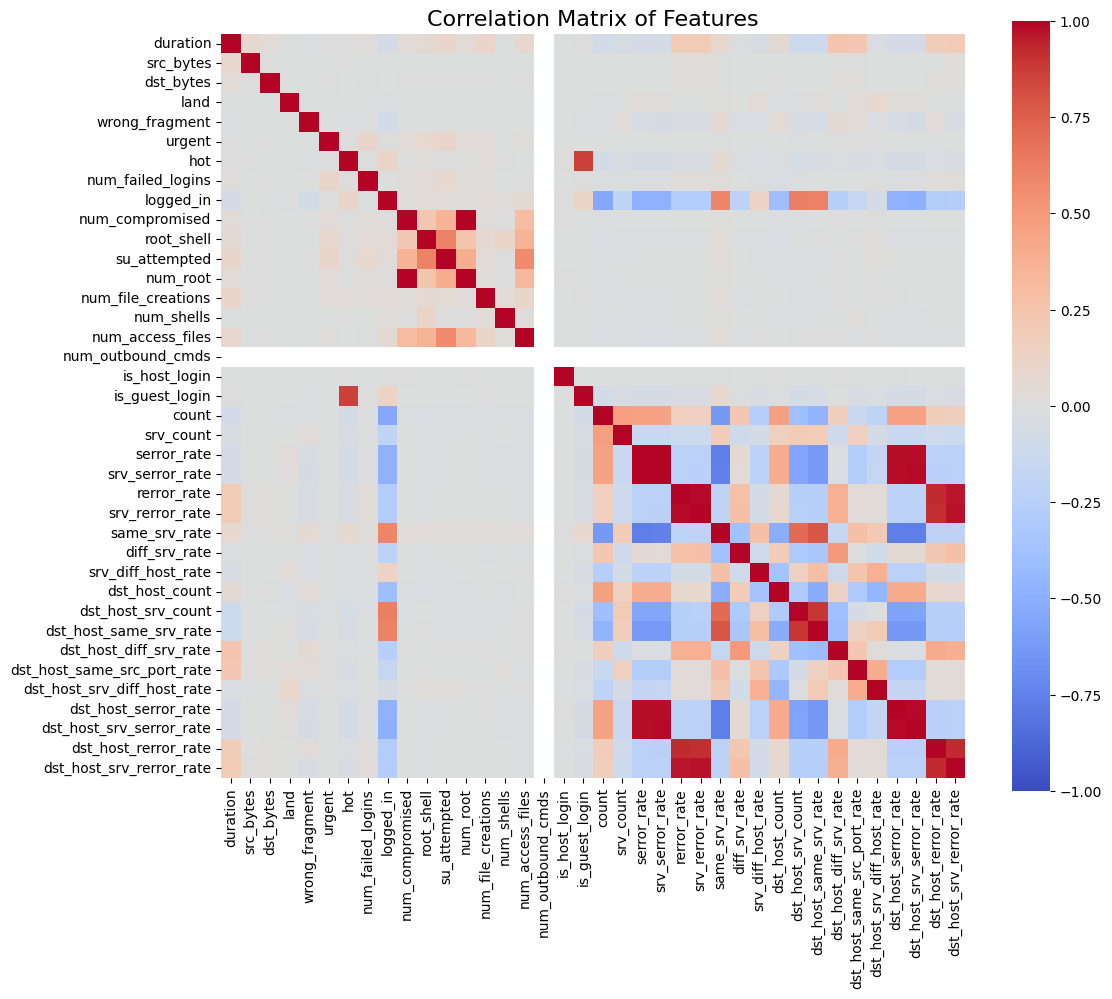

Generating Boxplots for key numerical features


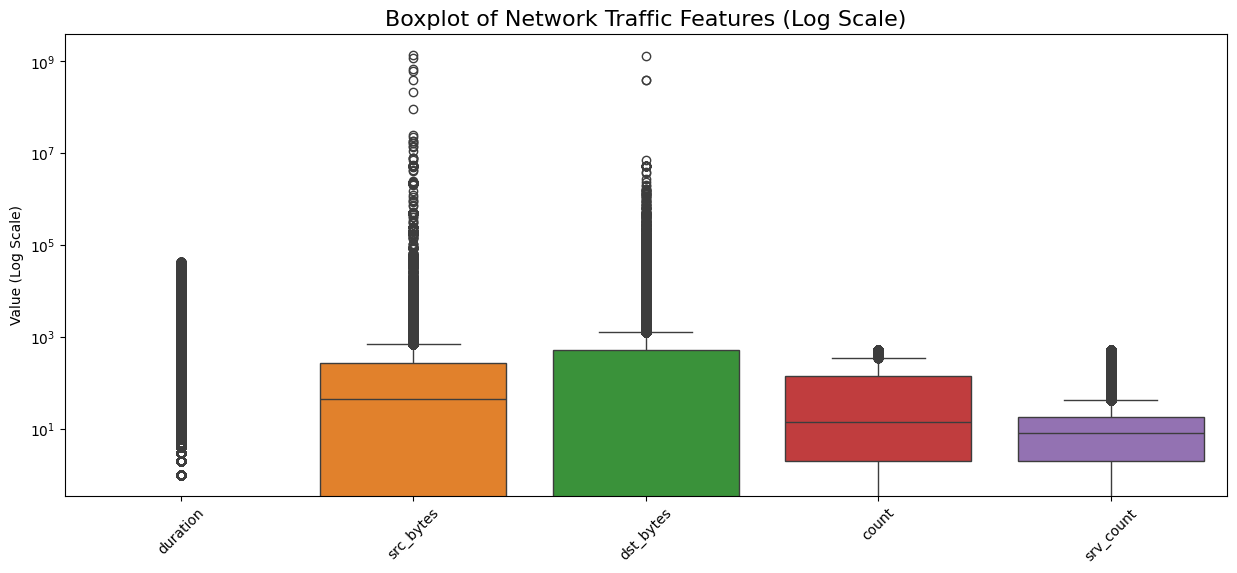

Generating Class Distribution Plot


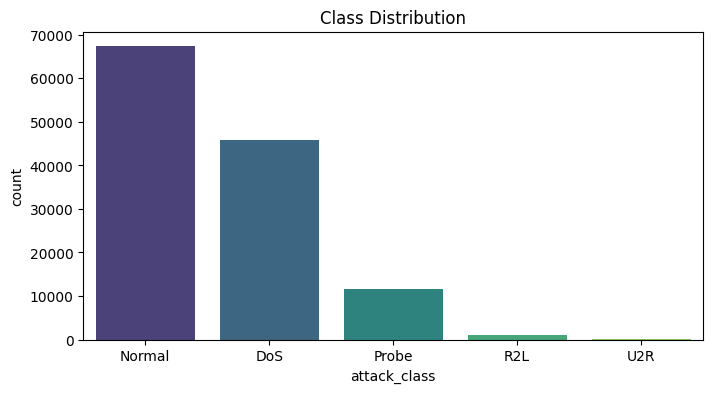

Class distribution stats:
attack_class
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [ ]:
# 3. ADVANCED VISUALIZATION


if 'attack_class' not in train_df.columns:
    print("Error: 'attack_class' column missing. Please rerun Cell 2.")
else:
    # 3.1 Correlation Heatmap
    print("Generating Correlation Heatmap")
    plt.figure(figsize=(12, 10))
    # Select only numeric columns for correlation (excluding 'attack_class')
    numeric_df = train_df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title('Correlation Matrix of Features', fontsize=16)
    plt.show()

    # 3.2 Boxplots for Outlier Visualization
    print("Generating Boxplots for key numerical features")
    # Features often having high variance
    features_to_plot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
    
    # Check if features exist in dataframe before plotting
    valid_features = [f for f in features_to_plot if f in train_df.columns]

    if valid_features:
        plt.figure(figsize=(15, 6))
        # Log scale handles extreme outliers better visually
        sns.boxplot(data=train_df[valid_features])
        plt.yscale('log')
        plt.title('Boxplot of Network Traffic Features (Log Scale)', fontsize=16)
        plt.ylabel('Value (Log Scale)')
        plt.xticks(rotation=45)
        plt.show()

    # 3.3 Class Balance (The part that failed)
    print("Generating Class Distribution Plot")
    plt.figure(figsize=(8, 4))
    sns.countplot(x='attack_class', data=train_df, palette='viridis', order=train_df['attack_class'].value_counts().index)
    plt.title('Class Distribution')
    plt.show()
    
    print("Class distribution stats:")
    print(train_df['attack_class'].value_counts())

In [ ]:
# 4. STATISTICAL OUTLIER DETECTION


print("Calculating Z-scores to identify statistical outliers")

# Select numerical columns
num_cols = train_df.select_dtypes(include=[np.number]).columns

# Calculate Z-scores
# scipy.stats.zscore returns a numpy array, losing the column names
z_scores = np.abs(stats.zscore(train_df[num_cols]))

# Define threshold
threshold = 3

# Summing boolean array returns a numpy array of counts
outliers_counts = (z_scores > threshold).sum(axis=0)

# Convert the numpy array back to a Pandas Series to link counts with column names
outliers = pd.Series(outliers_counts, index=num_cols)

print(f"\nNumber of outliers detected per feature (Z-score > {threshold}):")
# Now we can use sort_values() because it is a Pandas Object
print(outliers[outliers > 0].sort_values(ascending=False).head(10))

# Note: In Intrusion Detection, outliers are often the attacks themselves
# Therefore, we will not remove them blindly, but it is crucial to identify them.
print("\nNOTE: Outliers were detected but kept, as they likely represent attack signatures (e.g., DoS attacks).")
# 4.1 Handling Duplicates
duplicates = train_df.duplicated().sum()
print(f"Duplicates found in train set: {duplicates}")
if duplicates > 0:
    train_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# 4.2 Feature Separation
X_train = train_df.drop('attack_class', axis=1)
y_train = train_df['attack_class']
X_test = test_df.drop('attack_class', axis=1)
y_test = test_df['attack_class']

# 4.3 Encoding Categorical Variables (One-Hot Encoding)
# We use pd.get_dummies and align to ensure train/test have same columns
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
# Align columns (fill missing columns in test with 0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 4.4 Encoding Target (Label Encoding)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 4.5 Scaling 
# Essential for convergence of Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete. Data shape:", X_train_scaled.shape)

Calculating Z-scores to identify statistical outliers

Number of outliers detected per feature (Z-score > 3):
srv_diff_host_rate             8144
dst_host_diff_srv_rate         5314
diff_srv_rate                  4237
dst_host_srv_diff_host_rate    3691
srv_count                      3259
count                          2661
duration                       1431
is_guest_login                 1187
wrong_fragment                 1090
hot                             822
dtype: int64

NOTE: Outliers were detected but kept, as they likely represent attack signatures.
Duplicates found in train set: 9
Duplicates removed.
Preprocessing complete. Data shape: (125964, 122)


In [10]:
# 5. HANDLING CLASS IMBALANCE (SMOTE)

from imblearn.over_sampling import SMOTE
from collections import Counter

print("Checking class distribution BEFORE resampling:")
print(pd.Series(y_train_enc).value_counts().sort_index())

# Initialize SMOTE
# random_state for reproducibility
smote = SMOTE(random_state=42)

print("\nApplying SMOTE to generate synthetic samples for minority classes")
# We apply this on Training data (scaled)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_enc)

print("Checking class distribution AFTER resampling:")
print(pd.Series(y_train_res).value_counts().sort_index())

print(f"\nOriginal Train shape: {X_train_scaled.shape}")
print(f"Resampled Train shape: {X_train_res.shape}")

# Update the variable names for the next steps so models use the balanced data
X_train_final = X_train_res
y_train_final = y_train_res

Checking class distribution BEFORE resampling:
0    45927
1    67343
2    11647
3      995
4       52
Name: count, dtype: int64

Applying SMOTE to generate synthetic samples for minority classes
Checking class distribution AFTER resampling:
0    67343
1    67343
2    67343
3    67343
4    67343
Name: count, dtype: int64

Original Train shape: (125964, 122)
Resampled Train shape: (336715, 122)


Original features: 122
Features retaining 95% variance: 89


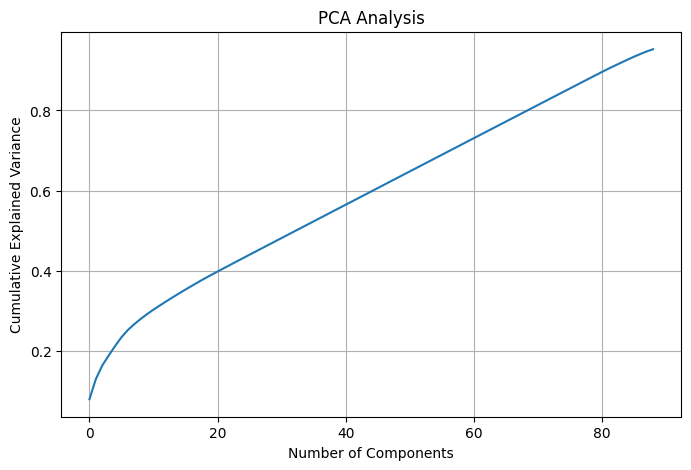

In [ ]:
# 5. DIMENSION REDUCTION (PCA ANALYSIS)


# Check how many components explain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features retaining 95% variance: {X_train_pca.shape[1]}")

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis')
plt.grid(True)
plt.show()

In [ ]:
# 7. HYPERPARAMETER TUNING (Random Forest on Balanced Data)


print("Tuning Random Forest using RandomizedSearchCV on SMOTE data")

# Parameter grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Randomized Search
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# FIT ON RESAMPLED DATA (X_train_final)
rf_search.fit(X_train_final, y_train_final)
best_rf = rf_search.best_estimator_

print(f"Best Random Forest Params: {rf_search.best_params_}")

Tuning Random Forest hyperparameters using RandomizedSearchCV
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Random Forest Params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 30}


In [ ]:
# 8. TRAINING MODELS & ENSEMBLE (With SMOTE)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest (Tuned)": best_rf,
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
}

# Advanced Ensemble: Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', models['XGBoost'])],
    voting='soft', n_jobs=-1
)
models["Voting Ensemble"] = voting_clf

results = []

print("Training models on Balanced Data & Evaluating on Original Test Data")

for name, model in models.items():
    start = time.time()
    
    model.fit(X_train_final, y_train_final)
    
    # We want to know how the model performs on real, unaltered traffic
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation Metrics
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    
    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1, "Time": time.time() - start})
    print(f"Done: {name} (F1: {f1:.4f})")

Starting model training
Model: Logistic Regression | CV Acc: 0.9887 | Test Acc: 0.7637 | Time: 27.83s
Model: Decision Tree | CV Acc: 0.9979 | Test Acc: 0.7641 | Time: 7.25s
Model: Random Forest (Tuned) | CV Acc: 0.9986 | Test Acc: 0.7614 | Time: 6.70s
Model: XGBoost | CV Acc: 0.9991 | Test Acc: 0.7711 | Time: 17.82s


In [ ]:
# 8. ENSEMBLE MODEL (Voting Classifier)

print("Training Voting Classifier (Ensemble)")

# Soft Voting: Weighted average of probabilities
# Combining RF and XGBoost as they are usually the strongest
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', models['XGBoost'])
    ],
    voting='soft',
    n_jobs=-1
)

start_v = time.time()
voting_clf.fit(X_train_scaled, y_train_enc)
y_pred_vote = voting_clf.predict(X_test_scaled)
acc_vote = accuracy_score(y_test_enc, y_pred_vote)
f1_vote = f1_score(y_test_enc, y_pred_vote, average='weighted')
time_v = time.time() - start_v

results.append({
    "Model": "Voting Ensemble",
    "CV Accuracy": "N/A", # Skipped for speed
    "Test Accuracy": acc_vote,
    "F1-Score": f1_vote,
    "Time (s)": time_v
})

print(f"Voting Classifier | Test Acc: {acc_vote:.4f} | F1-Score: {f1_vote:.4f}")

Training Voting Classifier (Ensemble)
Voting Classifier | Test Acc: 0.7704 | F1-Score: 0.7310



Final Results:
                   Model CV Accuracy  Test Accuracy  F1-Score   Time (s)
3                XGBoost    0.999095       0.771114  0.732269  19.182394
4        Voting Ensemble         N/A       0.770360  0.730976  20.731255
1          Decision Tree    0.997872       0.764106  0.724892   7.388164
0    Logistic Regression    0.988735       0.763662  0.722490  27.439354
2  Random Forest (Tuned)    0.998619       0.761356  0.720188   7.093976


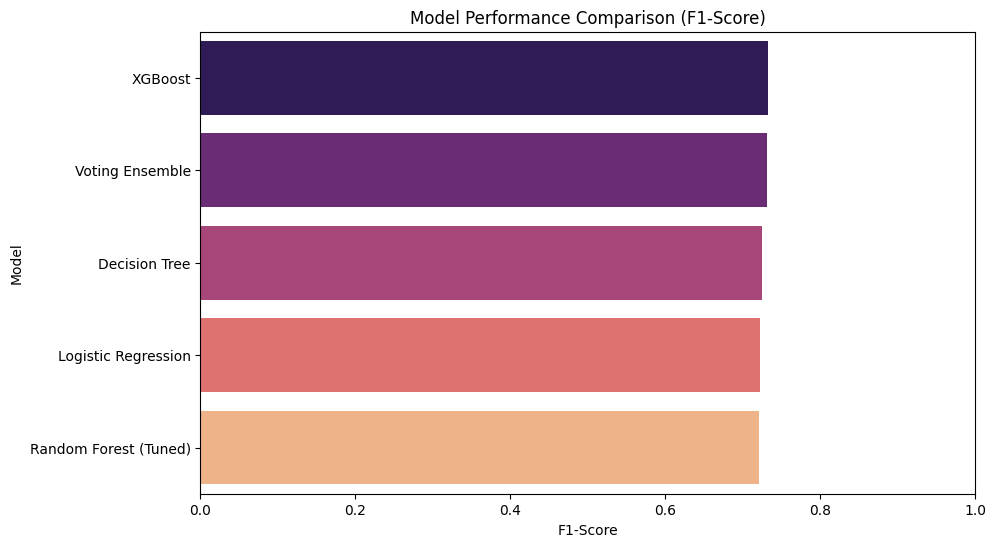


Detailed Report for Best Model: XGBoost
              precision    recall  f1-score   support

         DoS       0.96      0.84      0.90      7458
      Normal       0.67      0.97      0.80      9713
       Probe       0.81      0.62      0.70      2421
         R2L       0.97      0.07      0.14      2885
         U2R       0.56      0.07      0.13        67

    accuracy                           0.77     22544
   macro avg       0.80      0.51      0.53     22544
weighted avg       0.82      0.77      0.73     22544



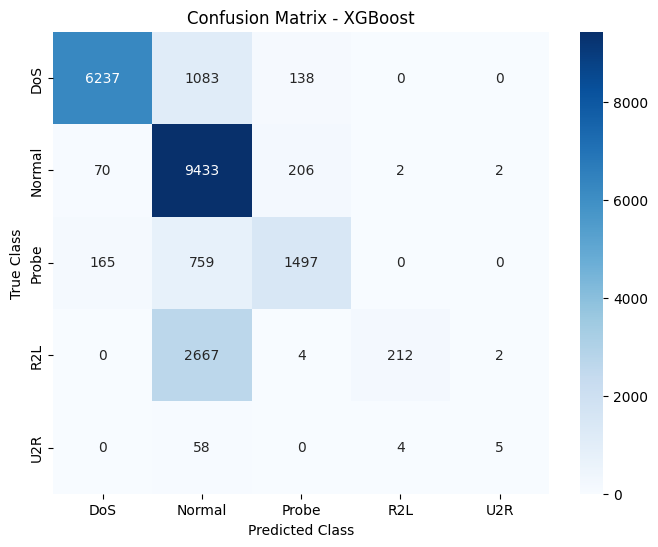

CONCLUSION: Tree-based ensemble methods (Random Forest, XGBoost) and Voting Classifiers demonstrate superior performance for detecting network intrusions compared to simple linear models.


In [ ]:
# 9. FINAL COMPARISON & CONCLUSION

# Create DataFrame
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\nFinal Results:")
print(results_df)

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', data=results_df, palette='magma')
plt.title('Model Performance Comparison (F1-Score)')
plt.xlim(0, 1.0)
plt.show()

# Detailed Report for the Best Model
best_model_name = results_df.iloc[0]['Model']
print(f"\nDetailed Report for Best Model: {best_model_name}")

if best_model_name == "Voting Ensemble":
    final_preds = y_pred_vote
else:
    
    final_model = voting_clf if "Voting" in best_model_name else models[best_model_name]
    final_preds = final_model.predict(X_test_scaled)

print(classification_report(y_test_enc, final_preds, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_enc, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

print("CONCLUSION: Tree-based ensemble methods (Random Forest, XGBoost) and Voting Classifiers demonstrate superior performance for detecting network intrusions compared to simple linear models.")